In [1]:
# 모듈 로딩
# 모델 관련 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score, MulticlassF1Score
from torchinfo import summary
import classes

# 데이터 및 시각화 관련 모듈
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [2]:
classes.check_version()

Pytorch v.2.4.1
Pandas v.2.0.3


In [3]:
# 데이터 로딩
DATA_FILE = '../../ML/Data/iris.csv'

irisDF = pd.read_csv(DATA_FILE)

irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa


In [4]:
irisDF['variety'] = irisDF['variety'].replace({'Setosa':0, 'Versicolor':1, 'Virginica':2})
irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0


In [5]:
model = classes.IrisMCFModel()
print(model)

IrisMCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [6]:
summary(model, input_size=(9000,4))

Layer (type:depth-idx)                   Output Shape              Param #
IrisMCFModel                             [9000, 3]                 --
├─Linear: 1-1                            [9000, 10]                50
├─Linear: 1-2                            [9000, 5]                 55
├─Linear: 1-3                            [9000, 3]                 18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 1.11
Input size (MB): 0.14
Forward/backward pass size (MB): 1.30
Params size (MB): 0.00
Estimated Total Size (MB): 1.44

In [7]:
featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[irisDF.columns[-1:]]

In [8]:
irisDS = classes.IrisDataset(featureDF, targetDF)

# 데이터로더 인스턴스
irisDL = DataLoader(irisDS)
for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[0.]])


In [9]:
EPOCH = 1000
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

In [10]:
# 모델 인스턴스
model = classes.IrisMCFModel().to(DEVICE)

In [11]:
# 학습/검증/테스트용 데이터 분리
X_train,X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)
print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')

## 학습/검증/테스트용 데이터셋
trainDS = classes.IrisDataset(X_train, y_train)
valDS = classes.IrisDataset(X_val, y_val)
testDS = classes.IrisDataset(X_test, y_test)

# 학습용 데이터로더 인스턴스 (검증용은 필요 없음, 테스트는 양이 많을 때 개발자가 선택하여 인스턴스 생성)
trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE)

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)


In [12]:
# 최적화 인스턴스 => W,b 텐서, 즉 model.parameters() 전달 - 최적화하는 이유 : 오차를 줄이기 위해서!
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 다중분류 : CrossEntropyLoss
#                            예측값은 확률값으로 전달 ==> sigmoid() AF 처리 후 전달
crossLoss = nn.CrossEntropyLoss()

In [13]:
## 학습의 효과 확인 - 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY = [[],[],[]], [[],[],[]]
CNT = len(trainDL)
print(f'CNT =>{CNT}')

## 학습 모니터링/스케줄링 설정 
# => LOSS_HISTORY, SCORE_HISTORY 활용
# => 임계 기준 : 10번
BREAK_CNT = 0
LIMIT_VALUE = 10

for epoch in range(EPOCH):
    # 학습 모드로 모델 성정
    model.train()

    # 배치크기만큼 데이터 로딩해서 학습 진행
    loss_total, score_total = 0,0
    for featureTS, targetTS in trainDL :
        # 학습 진행
        pre_y = model(featureTS)

        # 손실계산 : CrossEntropyLoss 요구사항 : 타겟(정답)은 0차원 또는 1차원, 타입은 long 
        loss = crossLoss(pre_y, targetTS.reshape(-1).long())
        loss_total += loss.item()

        # 성능평가 계산 : MulticlassF1Score 타입은 long으로 바꾸면 안됨
        score = MulticlassF1Score(num_classes=3)(pre_y, targetTS.reshape(-1))
        # 방법2 : score = F1Score(task='multiclass', num_classes = 3)(pre_y, targetTS)
        score_total += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()

    with torch.no_grad():
        # 검증용 데이터셋 생성
        val_feature_TS = torch.FloatTensor(valDS.featureDF.values)
        val_target_TS = torch.FloatTensor(valDS.targetDF.values)

        test_featureTS = torch.FloatTensor(testDS.featureDF.values)
        test_targetTS = torch.FloatTensor(testDS.targetDF.values)
        
        # 평가
        pre_val = model(val_feature_TS)
        pre_test = model(test_featureTS)
        # 손실 계산
        loss_val = crossLoss(pre_val, val_target_TS.reshape(-1).long())
        loss_test = crossLoss(pre_test, test_targetTS.reshape(-1).long())
        # 성능 평가
        score_val = MulticlassF1Score(num_classes=3)(pre_val, val_target_TS.reshape(-1))
        score_test = MulticlassF1Score(num_classes=3)(pre_test, test_targetTS.reshape(-1))

    # 에포크 당 손실과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT)
    
    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)

    LOSS_HISTORY[2].append(loss_test)
    SCORE_HISTORY[2].append(score_test)

    print(f'[{epoch}/{EPOCH}]\n- Train Loss : {LOSS_HISTORY[0][-1]} Score : {SCORE_HISTORY[0][-1]}')
    print(f'- Val Loss : {LOSS_HISTORY[1][-1]} Score : {SCORE_HISTORY[1][-1]}')
    print(f'- Test Loss : {LOSS_HISTORY[2][-1]} Score : {SCORE_HISTORY[2][-1]}')
    
    # 학습 진행 모니터링/스케줄링 - 검증 DS 기준 (둘 중에 하나만 선택)
    # # Loss 기준
    # if len(LOSS_HISTORY[1]) > 1:
    #     if LOSS_HISTORY[1][-1] >= LOSS_HISTORY[1][-2] : BREAK_CNT += 1 
    # Score 기준
    if len(SCORE_HISTORY[1]) > 1:
        if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2] : BREAK_CNT += 1 

    # 학습 중단 여부 설정
    if BREAK_CNT > LIMIT_VALUE :
        print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
        break


CNT =>9
[0/1000]
- Train Loss : 1.231225139564938 Score : 0.173298925989204
- Val Loss : 1.2244336605072021 Score : 0.18803419172763824
- Test Loss : 1.343672752380371 Score : 0.12765957415103912
[1/1000]
- Train Loss : 1.17257778512107 Score : 0.173298925989204
- Val Loss : 1.154613733291626 Score : 0.18803419172763824
- Test Loss : 1.2649086713790894 Score : 0.12765957415103912
[2/1000]
- Train Loss : 1.1225718590948317 Score : 0.173298925989204
- Val Loss : 1.0908712148666382 Score : 0.18803419172763824
- Test Loss : 1.1969952583312988 Score : 0.12765957415103912
[3/1000]
- Train Loss : 1.0785394377178616 Score : 0.173298925989204
- Val Loss : 1.033213496208191 Score : 0.18803419172763824
- Test Loss : 1.1396892070770264 Score : 0.12765957415103912
[4/1000]
- Train Loss : 1.0455736385451422 Score : 0.173298925989204
- Val Loss : 0.9883691668510437 Score : 0.18803419172763824
- Test Loss : 1.1020554304122925 Score : 0.12765957415103912
[5/1000]
- Train Loss : 1.0204222864574857 Score

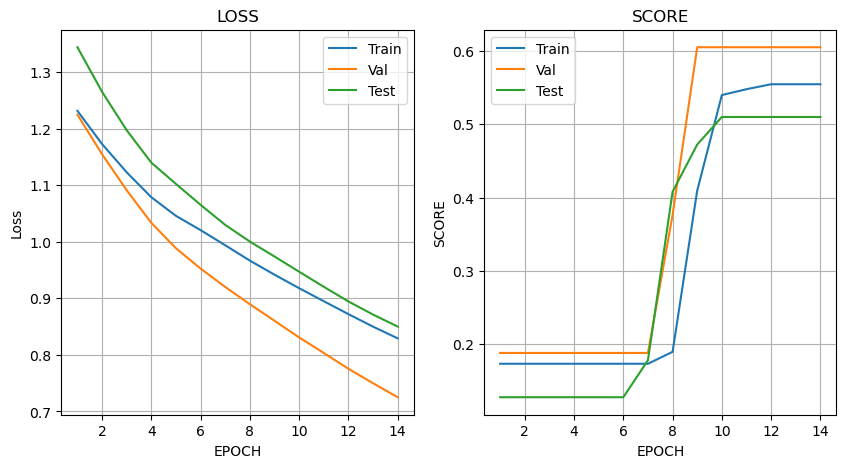

In [14]:
# 학습 후 LOSS 시각화
TH = len(LOSS_HISTORY[0])
fg, axes = plt.subplots(1,2, figsize=(10,5), sharex=True)

axes[0].plot(range(1,TH+1),LOSS_HISTORY[0][:TH], label='Train')
axes[0].plot(range(1,TH+1),LOSS_HISTORY[1][:TH], label='Val')
axes[0].plot(range(1,TH+1),LOSS_HISTORY[2][:TH], label='Test')
axes[0].grid('--')
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,TH+1),SCORE_HISTORY[0][:TH], label='Train')
axes[1].plot(range(1,TH+1),SCORE_HISTORY[1][:TH], label='Val')
axes[1].plot(range(1,TH+1),SCORE_HISTORY[2][:TH], label='Test')
axes[1].grid('--')
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('SCORE')
axes[1].set_title('SCORE')
plt.show()